Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.VXD4CP_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


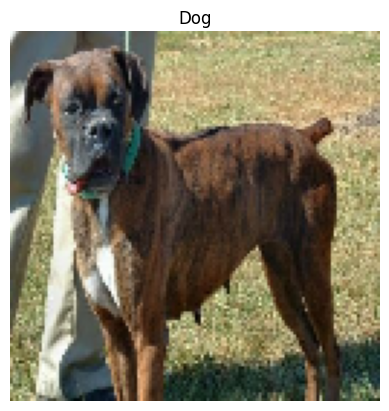

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# โหลด dataset
dataset_name = "cats_vs_dogs"
dataset, info = tfds.load(dataset_name, as_supervised=True, with_info=True)

# แยก Train และ Test
train_data, test_data = dataset["train"].take(20000), dataset["train"].skip(20000)

# ฟังก์ชันเตรียมข้อมูล (Resize + Normalize)
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize เป็น 128x128
    image = tf.cast(image, tf.float32) / 255.0  # Normalize ค่า Pixel
    return image, label

# ใช้ .map() เพื่อเตรียมข้อมูล
train_data = train_data.map(preprocess).batch(32)
test_data = test_data.map(preprocess).batch(32)

# แสดงภาพตัวอย่าง
for image, label in train_data.take(1):
    plt.imshow(image[0].numpy())
    plt.title("Cat" if label[0].numpy() == 0 else "Dog")
    plt.axis("off")
    plt.show()


In [ ]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# ฟังก์ชันดึง Feature ด้วย HOG
def extract_hog_features(dataset, num_samples=5000):
    X, y = [], []
    for image, label in dataset.unbatch().take(num_samples):
        img = image.numpy()
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # แปลงเป็น Grayscale
        feature = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2))  # ดึง Feature
        X.append(feature)
        y.append(label.numpy())
    return np.array(X), np.array(y)

# ดึง Feature จาก Train และ Test
X_train, y_train = extract_hog_features(train_data, num_samples=5000)
X_test, y_test = extract_hog_features(test_data, num_samples=1000)

# แบ่งข้อมูลออกเป็น Train และ Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# สร้างและ Train โมเดล SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred_svm = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred_svm)
print(f"Accuracy of SVM Model: {svm_accuracy:.2f}")

Accuracy of SVM Model: 0.67


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# สร้างและ Train โมเดล Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred_rf = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy of Random Forest Model: {rf_accuracy:.2f}")


Accuracy of Random Forest Model: 0.68


In [ ]:
import joblib

# บันทึกโมเดล SVM และ Random Forest
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(rf_model, "rf_model.pkl")


['rf_model.pkl']

In [ ]:
print("Performance Comparison:")
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")


Performance Comparison:
SVM Accuracy: 0.67
Random Forest Accuracy: 0.68


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# สร้างโมเดล CNN
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# คอมไพล์โมเดล
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# เทรนโมเดล
cnn_history = cnn_model.fit(train_data, epochs=10, validation_data=test_data)

# ทดสอบโมเดล
cnn_loss, cnn_acc = cnn_model.evaluate(test_data)
print(f"Test Accuracy of CNN Model: {cnn_acc:.2f}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.5899 - loss: 0.6597 - val_accuracy: 0.7419 - val_loss: 0.5162
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - accuracy: 0.7471 - loss: 0.5157 - val_accuracy: 0.7974 - val_loss: 0.4388
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.8041 - loss: 0.4312 - val_accuracy: 0.8170 - val_loss: 0.3969
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.8376 - loss: 0.3698 - val_accuracy: 0.8262 - val_loss: 0.3732
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 706s 1s/step - accuracy: 0.8628 - loss: 0.3186 - val_accuracy: 0.8296 - val_loss: 0.4020
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 774s 1s/step - accuracy: 0.8829 - loss: 0.2740 - val_accuracy: 0.8225 - val_loss: 0.4369
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9018 - loss: 0.2280 - val_accuracy: 0.8342 - val_loss: 0.4400
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - accuracy: 0.9180 - loss: 0.1972 - val_accuracy: 0.832

In [ ]:
cnn_model.save("cnn_model.h5")

In [ ]:
print("📊 Performance Comparison:")
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"CNN Accuracy: {cnn_acc:.2f}")

📊 Performance Comparison:
SVM Accuracy: 0.67
Random Forest Accuracy: 0.68
CNN Accuracy: 0.84


In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok
!ngrok authtoken 2uMXIfPkL2hiCelx9Z5KTkg6cJw_2ckkdVscLf6dccbkyP8DU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os
from pyngrok import ngrok

# กำหนดพอร์ตสำหรับ Streamlit
port = 8501

# รัน Streamlit ใน Background
os.system(f"streamlit run app.py &")

# เปิด Ngrok tunnel
public_url = ngrok.connect(port).public_url
print(f"🌍 เปิด Web App ที่: {public_url}")


🌍 เปิด Web App ที่: https://8bee-35-227-141-222.ngrok-free.app


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

# โหลดโมเดล CNN ที่เทรนไว้
cnn_model = tf.keras.models.load_model("cnn_model.h5")

# โหลดโมเดล ML (SVM และ Random Forest)
svm_model = joblib.load("svm_model.pkl")
rf_model = joblib.load("rf_model.pkl")

# ฟังก์ชัน Preprocess รูปภาพ
def preprocess_image(image):
    image = image.resize((128, 128))  # Resize
    img_array = np.array(image) / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)

def extract_hog_feature(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    feature = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    return feature.reshape(1, -1)

# UI หน้าแรก
st.title("🐶🐱 Cat vs Dog Classification Web App")
st.sidebar.title("🔍 Select a Page")
page = st.sidebar.radio("Go to", ["🏠 Home", "📊 Data & Model", "🤖 Machine Learning", "🧠 Neural Network"])

if page == "🏠 Home":
    st.header("Welcome to the Cat vs Dog Classifier! 🐱🐶")
    st.write("This app allows users to upload images of cats or dogs and classify them using Machine Learning and Deep Learning models.")

elif page == "📊 Data & Model":
    st.header("📊 Data & Model Information")
    st.write("### Dataset Used: TensorFlow Cats vs Dogs")
    st.write("The dataset contains **25,000 images** of cats and dogs, used to train models.")

    st.write("### Algorithms Used:")
    st.write("- **SVM & Random Forest (Machine Learning)**")
    st.write("- **CNN (Deep Learning)**")

elif page == "🤖 Machine Learning":
    st.header("🤖 Predict using Machine Learning (SVM & Random Forest)")
    uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Extract HOG Feature
        feature = extract_hog_feature(image)

        # Predict using SVM
        prediction_svm = svm_model.predict(feature)[0]
        prediction_rf = rf_model.predict(feature)[0]

        labels = ["Cat", "Dog"]

        st.write(f"**SVM Prediction:** {labels[prediction_svm]}")
        st.write(f"**Random Forest Prediction:** {labels[prediction_rf]}")

elif page == "🧠 Neural Network":
    st.header("🧠 Predict using Deep Learning (CNN)")
    uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Preprocess image for CNN
        processed_image = preprocess_image(image)

        # Predict using CNN
        prediction_cnn = cnn_model.predict(processed_image)
        predicted_label = np.argmax(prediction_cnn)

        labels = ["Cat", "Dog"]

        st.write(f"**CNN Prediction:** {labels[predicted_label]}")


2025-03-15 17:30:04.318 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.778 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-15 17:30:04.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.795 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-15 17:30:04.805 Thread 'MainThread': mi

In [ ]:
!pip install streamlit pyngrok


In [ ]:
!ngrok authtoken 2uMXIfPkL2hiCelx9Z5KTkg6cJw_2ckkdVscLf6dccbkyP8DU


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os
from pyngrok import ngrok

port = 8501
os.system(f"streamlit run app.py &")
public_url = ngrok.connect(port).public_url
print(f"🌍 เปิด Web App ที่: {public_url}")


🌍 เปิด Web App ที่: https://b8c9-35-227-141-222.ngrok-free.app
